In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Parameters
vocab_size = 1000
embedding_dim = 100  # Adjusted for GloVe 100d
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = 0.8

# Load data
data = pd.read_csv('data.csv')  # Ensure your CSV file is correctly formatted
sentences = data['text'].str.lower().tolist()
labels = data['label'].tolist()

In [3]:
# Daftar stopwords
stopword = [
    "yang", "dan", "di", "ke", "dari", "untuk", "dengan", "pada", "adalah",
    "ini", "itu", "saya", "kita", "anda", "akan", "telah", "sebagai", "atau",
    "jadi", "karena", "tidak", "dalam", "lebih", "lagi", "hanya", "sudah", "juga"
]

# Preprocessing
processed_sentences = []
for sentence in sentences:
    for word in stopword:
        sentence = sentence.replace(f" {word} ", " ")
    processed_sentences.append(sentence.strip())

In [4]:
# Split data
train_size = int(len(processed_sentences) * training_portion)
train_sentences = processed_sentences[:train_size]
train_labels = labels[:train_size]
validation_sentences = processed_sentences[train_size:]
validation_labels = labels[train_size:]

# Tokenization and Padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

training_label_seq = np.array(train_labels)
validation_label_seq = np.array(validation_labels)

In [5]:
# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Create an embedding matrix
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Load GloVe embeddings
embeddings_index = load_glove_embeddings('glove.6B.100d.txt')  # Adjust the path as necessary

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index, embeddings_index, embedding_dim)

In [6]:
# Improved CNN Model with pre-trained embeddings
model = models.Sequential([
    layers.Embedding(input_dim=len(word_index) + 1, 
                     output_dim=embedding_dim, 
                     weights=[embedding_matrix], 
                     input_length=max_length, 
                     trainable=False),  # Set trainable to False to freeze the embeddings
    layers.Conv1D(256, 5, activation='relu'),  # Increased number of filters
    layers.MaxPooling1D(pool_size=2),  # Added MaxPooling
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),  # Added Dropout to prevent overfitting
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Added Dropout
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='softmax')  # Adjust output layer based on your number of classes
])

# Compile Model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.001),  # Adjust learning rate if necessary
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)


# Train Model
history = model.fit(train_padded, training_label_seq, 
                    epochs=10, 
                    validation_data=(validation_padded, validation_label_seq), 
                    callbacks=[early_stopping])


C:\Users\adisu\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.1604 - loss: 2.0720 - val_accuracy: 0.3887 - val_loss: 1.7385
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3923 - loss: 1.6636 - val_accuracy: 0.6137 - val_loss: 1.1525
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5724 - loss: 1.1973 - val_accuracy: 0.7613 - val_loss: 0.7437
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6863 - loss: 0.8949 - val_accuracy: 0.7912 - val_loss: 0.6187
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7555 - loss: 0.7405 - val_accuracy: 0.8188 - val_loss: 0.5669
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7987 - loss: 0.6094 - val_accuracy: 0.8250 - val_loss: 0.5413
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8314 - loss: 0.4923 - val_accuracy: 0.8100 - val_loss: 0.5597
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8568 - loss: 0.4555 - val_ac

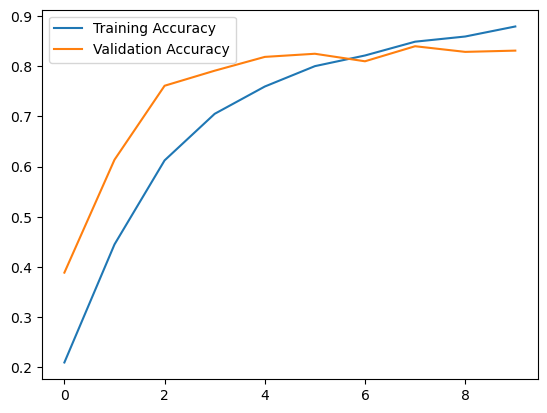

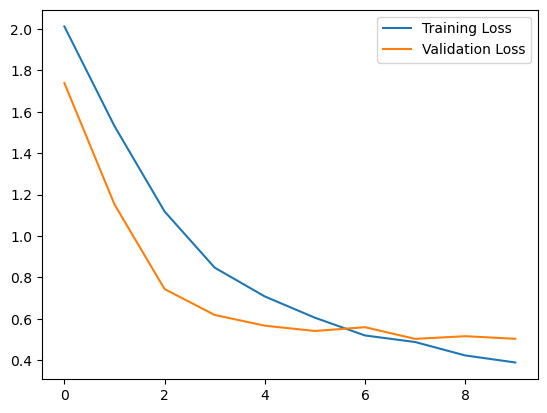

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8394 - loss: 0.4967
Validation Loss: 0.504
Validation Accuracy: 0.831


In [7]:
# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate Model
loss, accuracy = model.evaluate(validation_padded, validation_label_seq)
print(f'Validation Loss: {loss:.3f}')
print(f'Validation Accuracy: {accuracy:.3f}')
